In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))



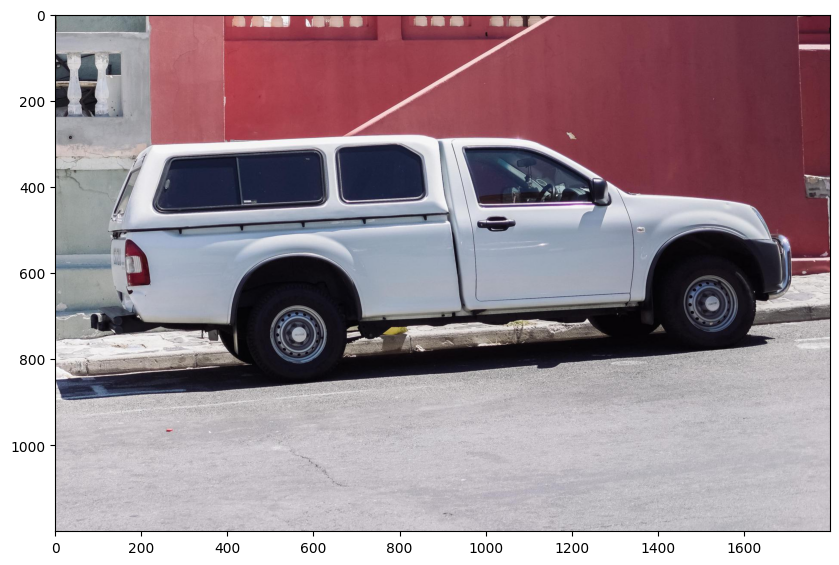

In [2]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [4]:
predictor.set_image(image)

In [5]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

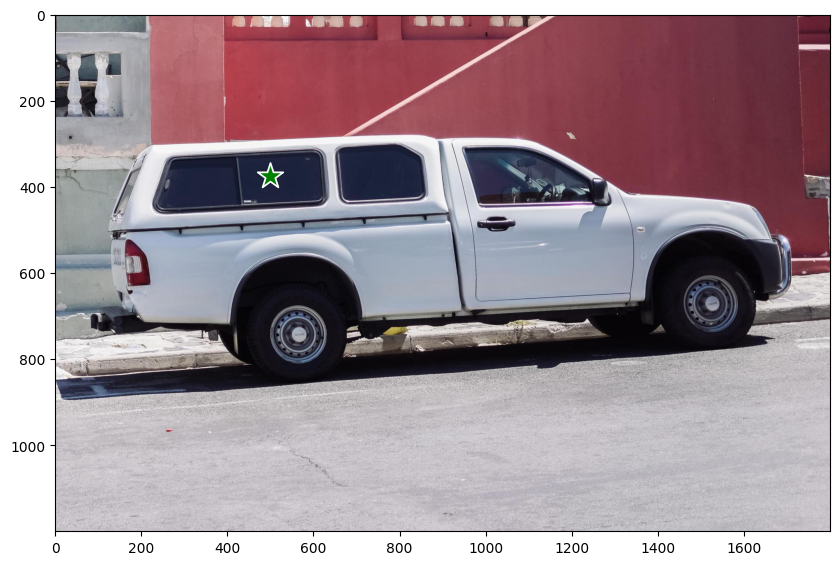

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [7]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [8]:
masks[0].shape  # (number_of_masks) x H x W

(1200, 1800)

최대값 : 1.0, 최소값 : 0.0


(-0.5, 1799.5, 1199.5, -0.5)

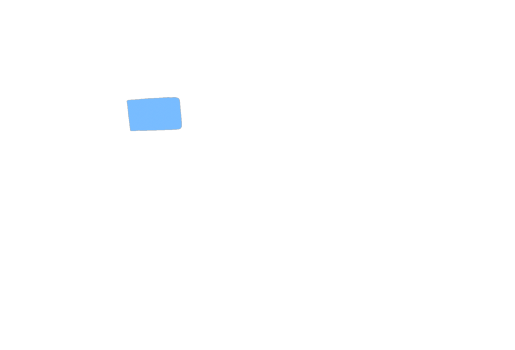

In [9]:
def show_mask_native(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    print(f"최대값 : {np.amax(mask_image)}, 최소값 : {np.amin(mask_image)}")
    ax.imshow(mask_image)
    # return mask_image

# plt.imshow(image)
show_mask_native(masks[0], plt.gca())
plt.axis('off')
# plt.show()


In [10]:
mask = masks[0]

color = np.array([30/255, 144/255, 255/255, 0.6])
h, w = mask.shape[-2:]
mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
mask_data = (mask_image * 255).astype(np.uint8)
mask_data = cv2.cvtColor(mask_data,cv2.COLOR_BGRA2RGBA)
image_rgba = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
masked_image = cv2.addWeighted(image_rgba, 1, mask_data, 1, 0)
result_image = cv2.cvtColor(masked_image, cv2.COLOR_RGBA2RGB)

cv2.imwrite("mask_image.png", result_image)

True

In [11]:
mask_data.shape

(1200, 1800, 4)

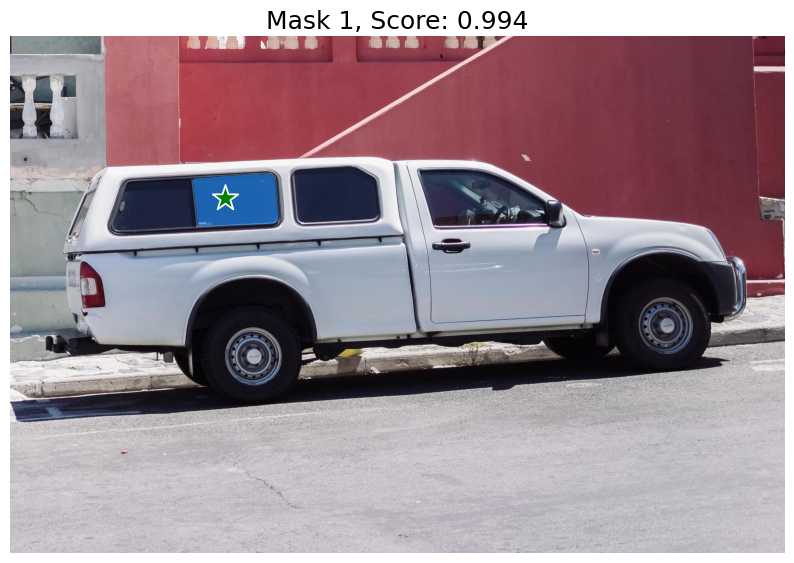

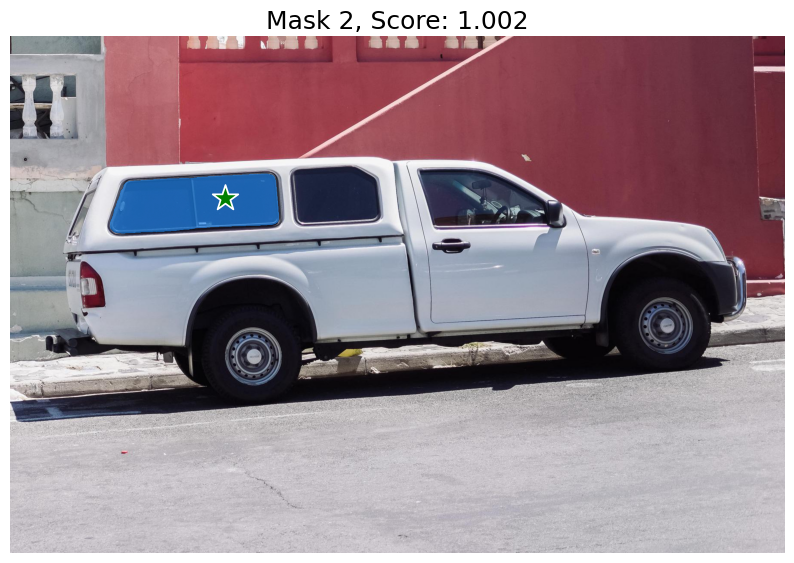

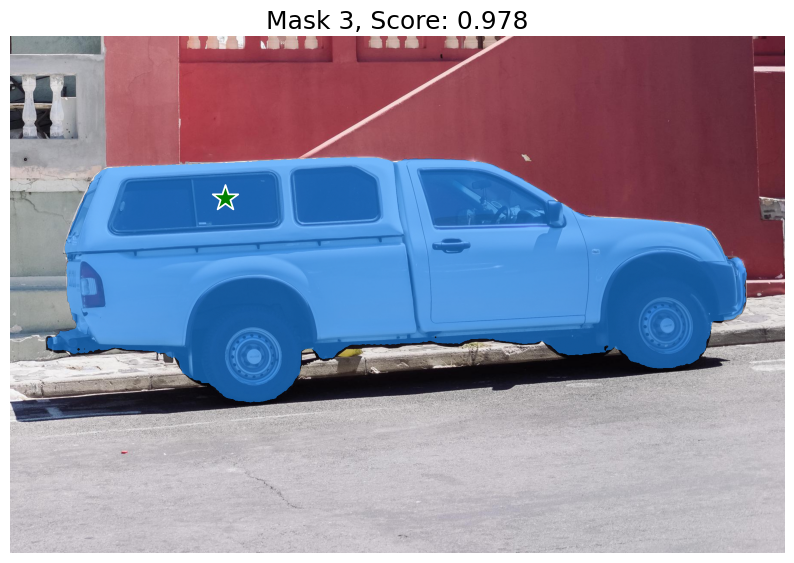

In [13]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [16]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0]) # 1 : mask

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [8]:
import numpy as np
coords=[[1,3],[2,3],[5,6]]
label = [1,0,1]

np.array(coords),np.array(label)

(array([[1, 3],
        [2, 3],
        [5, 6]]),
 array([1, 0, 1]))

In [17]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

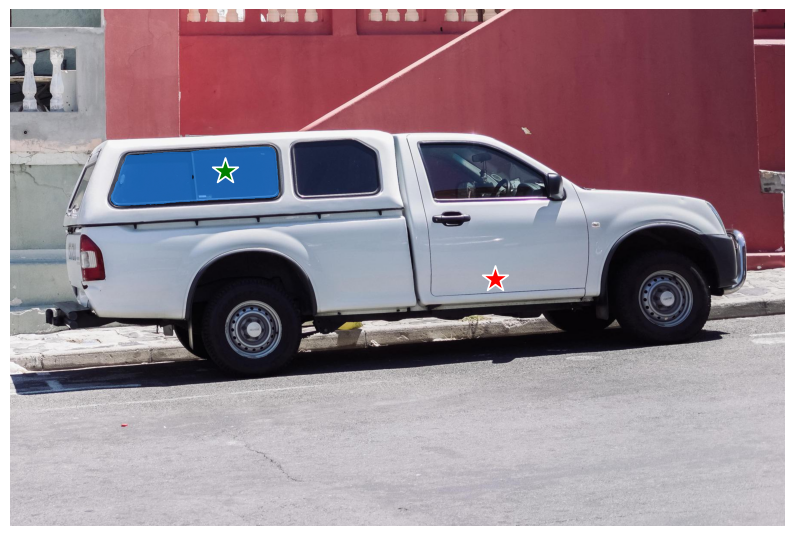

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [17]:
input_box = np.array([425, 600, 700, 875])

In [18]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

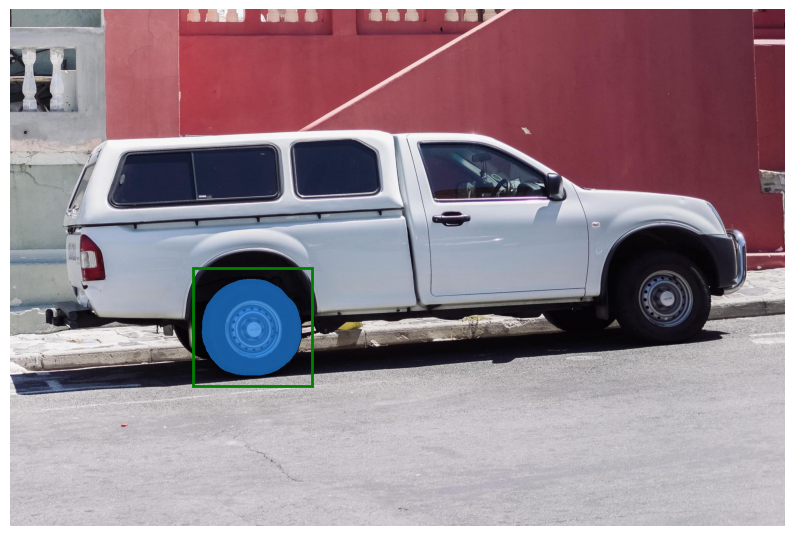

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [20]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [21]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

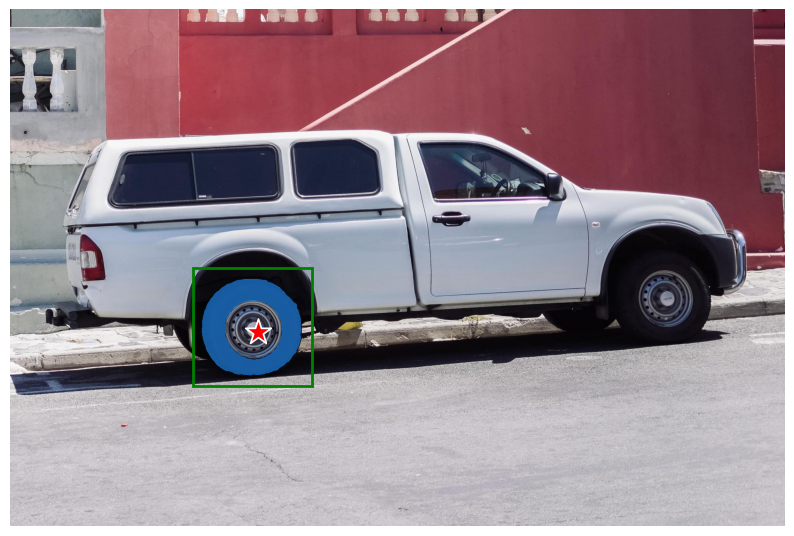

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

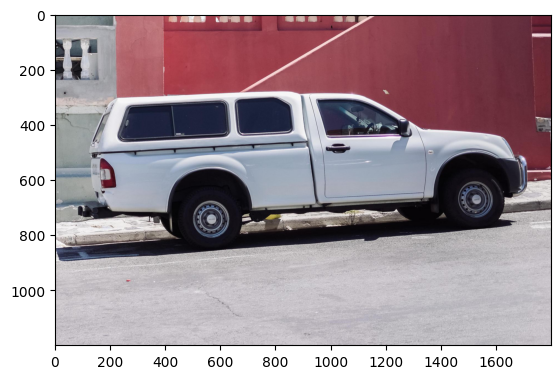

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Load an example image
img = plt.imread('images/truck.jpg')

# Create a figure and axes
fig, ax = plt.subplots()
plt.imshow(img)

# Create a text box to display the coordinates
# out = widgets.Output()
# display(out)

# Define a function to handle the on-click event
# def onclick(event):
#     out.clear_output()
#     x = int(event.xdata)
#     y = int(event.ydata)
#     with out:
#         print(f"({x}, {y})")
def onclick(event):
    x = event.xdata
    y = event.ydata
    print(f"({x}, {y})")

# Connect the on-click event to the figure
# cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig = plt.gcf()
cid = fig.canvas.mpl_connect('button_press_event', onclick)